In [1]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score
from hyperopt import tpe, hp, fmin, Trials, STATUS_OK
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt
cur_path = os.getcwd()
df = pd.read_csv(cur_path+"\\train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1590 entries, 0 to 1589
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   1590 non-null   int64 
 1   Age                  1590 non-null   int64 
 2   Employment Type      1590 non-null   object
 3   GraduateOrNot        1590 non-null   object
 4   AnnualIncome         1590 non-null   int64 
 5   FamilyMembers        1590 non-null   int64 
 6   ChronicDiseases      1590 non-null   int64 
 7   FrequentFlyer        1590 non-null   object
 8   EverTravelledAbroad  1590 non-null   object
 9   TravelInsurance      1590 non-null   int64 
dtypes: int64(6), object(4)
memory usage: 124.3+ KB


In [2]:
cat_col = ['Employment Type', 'GraduateOrNot','ChronicDiseases', 'FrequentFlyer','EverTravelledAbroad']
num_col = ['Age','AnnualIncome','FamilyMembers']
len(cat_col)+len(num_col)

8

In [3]:
for i in cat_col:
    print("\n\n",i,"\n")
    print(df[i].value_counts())



 Employment Type 

Private Sector/Self Employed    1130
Government Sector                460
Name: Employment Type, dtype: int64


 GraduateOrNot 

Yes    1353
No      237
Name: GraduateOrNot, dtype: int64


 ChronicDiseases 

0    1147
1     443
Name: ChronicDiseases, dtype: int64


 FrequentFlyer 

No     1251
Yes     339
Name: FrequentFlyer, dtype: int64


 EverTravelledAbroad 

No     1280
Yes     310
Name: EverTravelledAbroad, dtype: int64


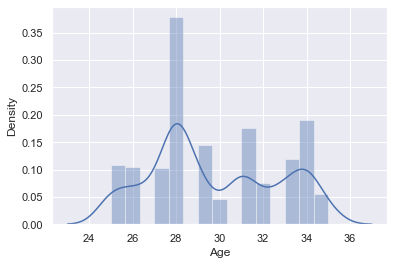

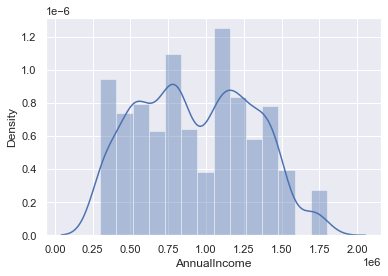

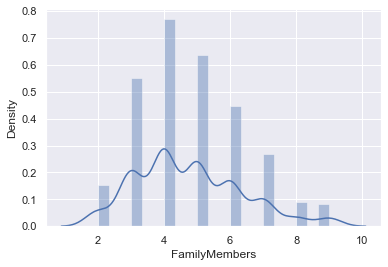

In [4]:
for x in num_col:
    plt.figure()
    sns.distplot(df[x]);

In [5]:
df.TravelInsurance.value_counts()

0    1014
1     576
Name: TravelInsurance, dtype: int64

<AxesSubplot:>

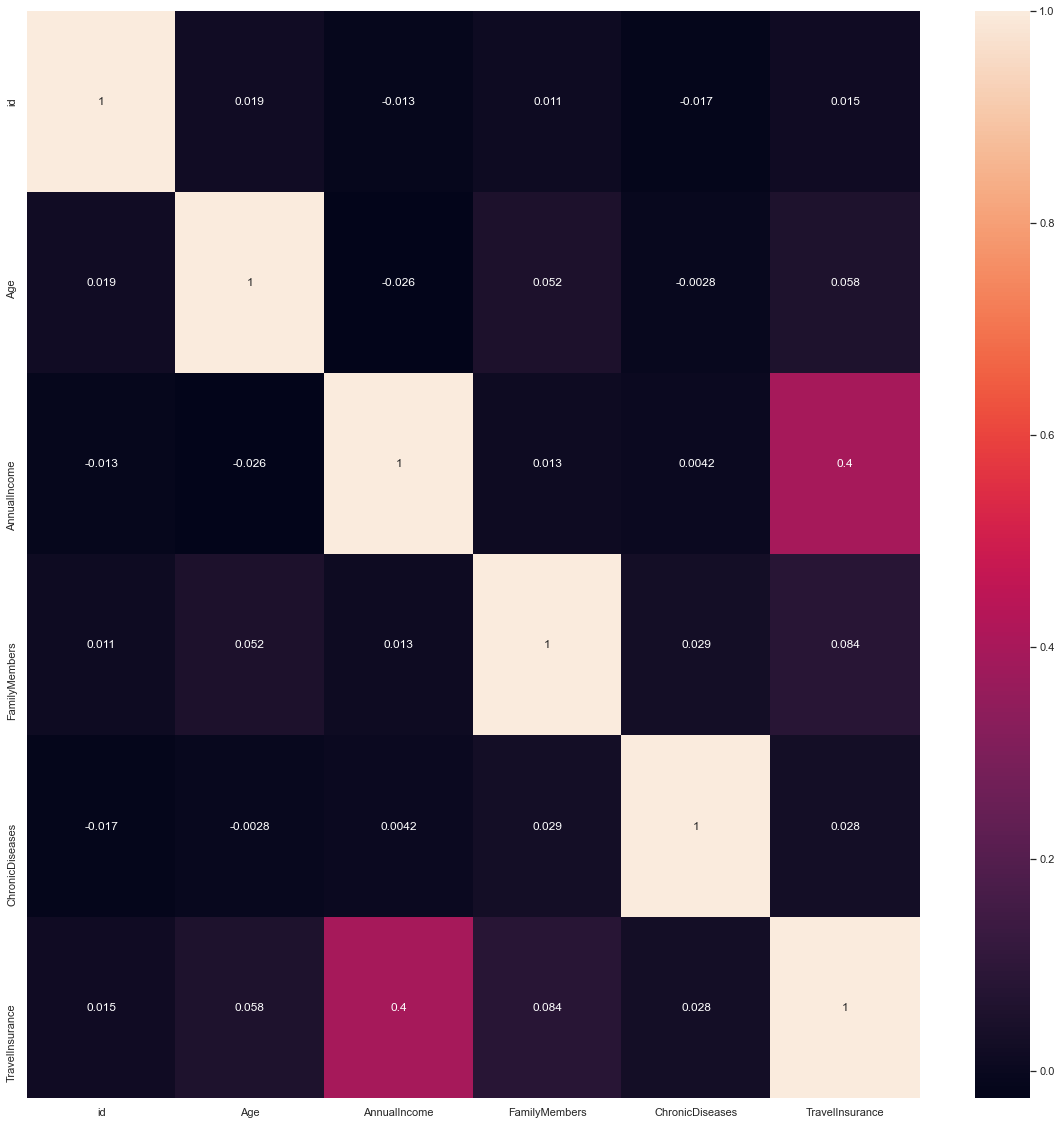

In [6]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(),annot=True)

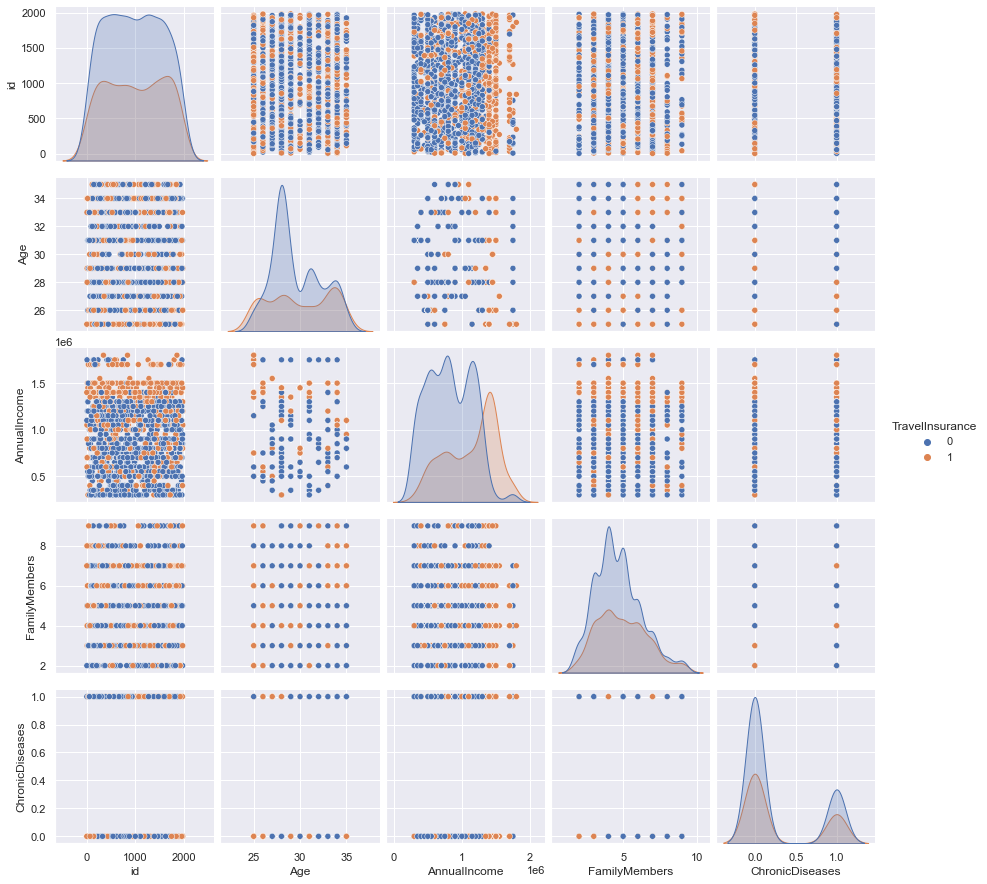

In [7]:
sns.pairplot(df,hue="TravelInsurance")

### Feature - Selection for xgboost

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler


# Categorical data
encoder = OrdinalEncoder()
#X = encoder.fit_transform(df[cat_col+num_col])
X_cat = encoder.fit_transform(df[cat_col])

# Numeric Data
scaler = StandardScaler()
scaler.fit(df[num_col])
X_num = scaler.transform(df[num_col])

X = np.c_[X_cat,X_num]
X_col_names = cat_col + num_col
y = df.TravelInsurance.to_numpy()

# Train - Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=42)
print(X_train.shape, y_train.shape)

(1272, 8) (1272,)


In [9]:
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [10]:
def modelfit(alg, xtrain, ytrain,xtest,ytest, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(xtrain, label=ytrain)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(xtrain, ytrain,eval_metric='auc')
        
    #Predict training set:
    train_predictions = alg.predict(xtrain)
    train_predprob1 = alg.predict_proba(xtrain)[:,1]
    train_predprob2 = alg.predict_proba(xtest)[:,1]    
    #Print model report:
    #print("\nModel Report")
    print("Accuracy : %.4g", metrics.accuracy_score(ytrain, train_predictions))
    print("AUC Score (Train): %f", metrics.roc_auc_score(ytrain, train_predprob1))
    print("AUC Score (Test): %f", metrics.roc_auc_score(ytest, train_predprob2))
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

Accuracy : %.4g 0.8262578616352201
AUC Score (Train): %f 0.877741815673582
AUC Score (Test): %f 0.8186409754360982


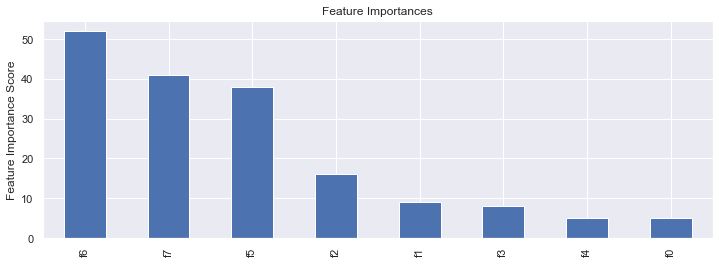

In [11]:
from xgboost.sklearn import XGBClassifier
from sklearn import metrics 
fetures = XGBClassifier(objective= 'binary:logistic',eval_metric="auc")
modelfit(fetures, X_train, y_train, X_test, y_test)

Looking at the graph we can conclude that the numerical features will give us the best results for the xgboost model. Here,

f0 - Employment Type

f1 - GraduateOrNot

f2 - ChronicDiseases

f3 - FrequentFlyer

f4 - EverTravelledAbroad

f5 - Age

f6 - AnnualIncome

f7 - FamilyMembers

### Pre-Processing

In [12]:
cat_col = ['Employment Type', 'GraduateOrNot','ChronicDiseases', 'FrequentFlyer','EverTravelledAbroad']
num_col = ['Age','AnnualIncome','FamilyMembers']
X_col_names = cat_col + num_col
# Finding the most important features for XGBoost
X_col_names[6], X_col_names[5], X_col_names[7]

('AnnualIncome', 'Age', 'FamilyMembers')

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Keeping only numerical features
scaler = StandardScaler()
num_col = ['AnnualIncome', 'Age', 'FamilyMembers']
scaler.fit(df[num_col])
X = scaler.transform(df[num_col])
y = df.TravelInsurance.to_numpy()

# Train - Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=42)
print(X_train.shape, y_train.shape)

(1272, 3) (1272,)


In [14]:
from xgboost.sklearn import XGBClassifier
from sklearn import metrics 

xgb = XGBClassifier(
 objective= 'binary:logistic',
 eval_metric="auc"
)
xgb.fit(X_train,y_train.ravel())
train_predictions = xgb.predict(X_test)
train_predprob1 = xgb.predict_proba(X_train)[:,1]
train_predprob2 = xgb.predict_proba(X_test)[:,1]    
#Print model report:
print("\nModel Report")
print("Accuracy :", metrics.accuracy_score(y_test, train_predictions))
print("AUC Score (Train):", metrics.roc_auc_score(y_train, train_predprob1))
print("AUC Score (Test):", metrics.roc_auc_score(y_test, train_predprob2))


Model Report
Accuracy : 0.789308176100629
AUC Score (Train): 0.932779752745795
AUC Score (Test): 0.8527723389106444


### Optimizing Hyperparameters

In [15]:
from hyperopt import tpe, hp, fmin, Trials, STATUS_OK

space={'max_depth': hp.quniform("max_depth", 4, 10, 1),
       'gamma': hp.uniform ('gamma', 0,9),
       #'learning_rate': hp.uniform ('learning_rate', 0,1),
       'min_child_weight' : hp.quniform('min_child_weight', 0, 5, 1),
       'max_delta_step' : hp.quniform('max_delta_step', 0, 5, 1),
       #'n_estimators': hp.quniform("n_estimators", 1000, 1200, 5),
       #'subsample': hp.uniform('subsample', 0,1),
       #'colsample_bytree': hp.uniform('colsample_bytree', 0,1),
       #'seed': 42
       }

def objective(space):
    clf = XGBClassifier(
         #n_estimators = int(space['n_estimators']),
         #learning_rate = int(space['learning_rate']),
         gamma = float(space['gamma']),
         min_child_weight  = int(space['min_child_weight']),
         max_depth = int(space['max_depth']),
         max_delta_step = int(space['max_delta_step']),
#         subsample = int(space['subsample']),
#         colsample_bytree = int(space['colsample_bytree'])
    )
    evaluation = [(X_train, y_train), (X_test, y_test)]
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric = 'auc',
            early_stopping_rounds = 10, verbose = False)
    pred = clf.predict_proba(X_test)[:,1]
    accuracy = metrics.roc_auc_score(y_test, pred)
    print('SCORE:', accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK}

trials = Trials()
best_hyperparameters = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 50, 
                            trials = trials)

SCORE:                                                                                                                 
0.8336596653613385                                                                                                     
SCORE:                                                                                                                 
0.8319686721253114                                                                                                     
SCORE:                                                                                                                 
0.836752402990388                                                                                                      
SCORE:                                                                                                                 
0.8319686721253114                                                                                                     
SCORE:                                  

SCORE:                                                                                                                 
0.8364186543253828                                                                                                     
SCORE:                                                                                                                 
0.8332369170523318                                                                                                     
SCORE:                                                                                                                 
0.8332369170523318                                                                                                     
SCORE:                                                                                                                 
0.8555313278746883                                                                                                     
SCORE:                                  

In [16]:
print(best_hyperparameters)

{'gamma': 0.24369649061437865, 'max_delta_step': 0.0, 'max_depth': 7.0, 'min_child_weight': 1.0}


In [17]:
xgb_1 = XGBClassifier(gamma= 0.11069607773711576,
                max_depth = 10,
                min_child_weight = 1,
                max_delta_step = 1,
#                n_estimators=1125,
                 objective= 'binary:logistic',
                # subsample = 0.7014646806559172,
                 eval_metric="auc"
)

xgb_1.fit(X_train,y_train.ravel())
train_predictions = xgb_1.predict(X_test)
train_predprob1 = xgb_1.predict_proba(X_train)[:,1]
train_predprob2 = xgb_1.predict_proba(X_test)[:,1]    
#Print model report:
print("\nModel Report")
print("Accuracy :", metrics.accuracy_score(y_test, train_predictions))
print("AUC Score (Train):", metrics.roc_auc_score(y_train, train_predprob1))
print("AUC Score (Test):", metrics.roc_auc_score(y_test, train_predprob2))


Model Report
Accuracy : 0.7987421383647799
AUC Score (Train): 0.9413646734228258
AUC Score (Test): 0.8528613385546457


{'gamma': 1.0284991041911118, 'max_delta_step': 5.0, 'max_depth': 4.0, 'min_child_weight': 1.0}

In [18]:
xgb_2 = XGBClassifier(gamma= 1.0284991041911118,
                max_depth = 4,
                min_child_weight = 1,
                max_delta_step = 5.,
                objective= 'binary:logistic',
                eval_metric="auc")

xgb_2.fit(X_train,y_train.ravel())
train_predictions = xgb_2.predict(X_test)
train_predprob1 = xgb_2.predict_proba(X_train)[:,1]
train_predprob2 = xgb_2.predict_proba(X_test)[:,1]    
#Print model report:
print("\nModel Report")
print("Accuracy :", metrics.accuracy_score(y_test, train_predictions))
print("AUC Score (Train):", metrics.roc_auc_score(y_train, train_predprob1))
print("AUC Score (Test):", metrics.roc_auc_score(y_test, train_predprob2))


Model Report
Accuracy : 0.8427672955974843
AUC Score (Train): 0.861231230434552
AUC Score (Test): 0.8341714133143467


In [25]:
xgb_3 = XGBClassifier(gamma= 0.24369649061437865,
                max_depth = 7,
                min_child_weight = 1,
                max_delta_step = 0,
                 objective= 'binary:logistic',
                 eval_metric="auc"
)

xgb_3.fit(X_train,y_train.ravel())
train_predictions = xgb_3.predict(X_test)
train_predprob1 = xgb_3.predict_proba(X_train)[:,1]
train_predprob2 = xgb_3.predict_proba(X_test)[:,1]    
#Print model report:
print("\nModel Report")
print("Accuracy :", metrics.accuracy_score(y_test, train_predictions))
print("AUC Score (Train):", metrics.roc_auc_score(y_train, train_predprob1))
print("AUC Score (Test):", metrics.roc_auc_score(y_test, train_predprob2))


Model Report
Accuracy : 0.8144654088050315
AUC Score (Train): 0.917104844272298
AUC Score (Test): 0.8555313278746883


xgb_1 is our current best model

### Predicting

In [26]:
test_temp = pd.read_csv(cur_path+"\\test.csv")
test_temp

,id,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad
0,0,27,Government Sector,Yes,500000,5,0,No,No
1,9,34,Private Sector/Self Employed,Yes,1050000,4,0,No,No
2,14,29,Private Sector/Self Employed,Yes,1200000,4,0,No,No
3,31,25,Private Sector/Self Employed,Yes,1400000,7,0,No,Yes
4,41,31,Private Sector/Self Employed,Yes,1400000,6,0,No,Yes
...,...,...,...,...,...,...,...,...,...
392,1968,29,Private Sector/Self Employed,Yes,1100000,3,0,No,No
393,1969,28,Government Sector,Yes,600000,4,0,Yes,No
394,1972,28,Private Sector/Self Employed,Yes,1450000,4,0,Yes,Yes
395,1983,25,Private Sector/Self Employed,No,1700000,5,0,Yes,Yes


In [29]:
test = scaler.transform(test_temp[num_col])
pred_sub = xgb_3.predict_proba(test)[:,1]
test_sub = pd.DataFrame()
test_sub['id'] = test_temp['id']
test_sub['TravelInsurance'] = pred_sub
test_sub

,id,TravelInsurance
0,0,0.081894
1,9,0.365191
2,14,0.161828
3,31,0.984060
4,41,0.668670
...,...,...
392,1968,0.280985
393,1969,0.118582
394,1972,0.986037
395,1983,0.843497


In [30]:
test_sub.to_csv('J014_submission21.csv', index=False)